<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_1_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Using Convolutions with LSTMs

Welcome to the final week of this course! In this lab, you will build upon the RNN models you built last week and append a convolution layer to it. As you saw in previous courses, convolution filters can also capture features from sequences so it's good to try them out when exploring model architectures. Let's begin!

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

You will be plotting the MAE and loss later so the `plot_series()` is extended to have more labelling functionality. The utilities for generating the synthetic data is the same as the previous labs.

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

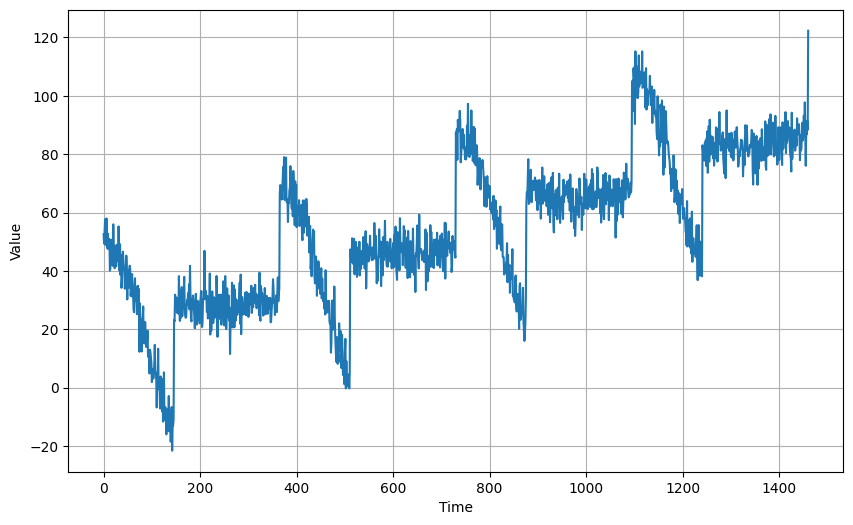

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series, xlabel='Time', ylabel='Value')

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

As mentioned in the lectures, you can experiment with different batch sizing here and see how it affects your results.

In [5]:
# Parameters
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [7]:
# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

Here is the model architecture you will be using. It is very similar to the last RNN you built but with the [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer at the input. One important [argument](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D#args) here is the `padding`. For time series data, it is good practice to not let computations for a particular time step to be affected by values into the future. Here is one way of looking at it:

* Let's say you have a small time series window with these values: `[1, 2, 3, 4, 5]`. This means the value `1` is at `t=0`, `2` is at `t=1`, etc.
* If you have a 1D kernel of size `3`, then the first convolution will be for the values at `[1, 2, 3]` which are values for `t=0` to `t=2`.
* When you pass this to the first timestep of the `LSTM` after the convolution, it means that the value at `t=0` of the LSTM depends on `t=1` and `t=2` which are values into the future.
* For time series data, you want computations to only rely on current and previous time steps.
* One way to do that is to pad the array depending on the kernel size and stride. For a kernel size of 3 and stride of 1, the window can be padded as such: `[0, 0, 1, 2, 3, 4, 5]`. `1` is still at `t=0` and two zeroes are prepended to simulate values in the past.
* This way, the first stride will be at `[0, 0, 1]` and this does not contain any future values when it is passed on to subsequent layers.

The `Conv1D` layer does this kind of padding by setting `padding=causal` and you'll see that below.

In [8]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

/Users/civye1/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,369 (259.25 KB)

 Trainable params: 66,369 (259.25 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

In the previous labs, you are using different models for tuning and training. That is a valid approach but you can also use the same model for both. Before tuning, you can use the [`get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights) method so you can reset it later.

In [9]:
# Get initial weights
init_weights = model.get_weights()

After that, you can tune the model as usual.

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 141.9408 - learning_rate: 1.0000e-08
Epoch 2/100
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 85.4310

2024-07-11 10:08:43.757249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/civye1/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 74.3230 - learning_rate: 1.1220e-08
Epoch 3/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26.6020

2024-07-11 10:08:44.129981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.2076 - learning_rate: 1.2589e-08
Epoch 4/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.8313

2024-07-11 10:08:44.495708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.9758 - learning_rate: 1.4125e-08
Epoch 5/100
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.3401

2024-07-11 10:08:44.857515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.4893 - learning_rate: 1.5849e-08
Epoch 6/100
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7786

2024-07-11 10:08:45.225199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.7773 - learning_rate: 1.7783e-08
Epoch 7/100
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2118

2024-07-11 10:08:45.664580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3409 - learning_rate: 1.9953e-08
Epoch 8/100
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5309

2024-07-11 10:08:46.026784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8622 - learning_rate: 2.2387e-08
Epoch 9/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2014

2024-07-11 10:08:46.400199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2408 - learning_rate: 2.5119e-08
Epoch 10/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7003

2024-07-11 10:08:46.758185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8811 - learning_rate: 2.8184e-08
Epoch 11/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8725

2024-07-11 10:08:47.139836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9465 - learning_rate: 3.1623e-08
Epoch 12/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6702

2024-07-11 10:08:47.503299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7677 - learning_rate: 3.5481e-08
Epoch 13/100
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1394

2024-07-11 10:08:47.867012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9078 - learning_rate: 3.9811e-08
Epoch 14/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4349

2024-07-11 10:08:48.236437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9149 - learning_rate: 4.4668e-08
Epoch 15/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3380

2024-07-11 10:08:48.613314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5132 - learning_rate: 5.0119e-08
Epoch 16/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4237

2024-07-11 10:08:48.974765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0849 - learning_rate: 5.6234e-08
Epoch 17/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1401

2024-07-11 10:08:49.336013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3800 - learning_rate: 6.3096e-08
Epoch 18/100
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2695

2024-07-11 10:08:49.697233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0763 - learning_rate: 7.0795e-08
Epoch 19/100
25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.3380

2024-07-11 10:08:50.061699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.4559 - learning_rate: 7.9433e-08
Epoch 20/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8191

2024-07-11 10:08:50.456429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6726 - learning_rate: 8.9125e-08
Epoch 21/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6118

2024-07-11 10:08:50.816402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4809 - learning_rate: 1.0000e-07
Epoch 22/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2395

2024-07-11 10:08:51.175818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2850 - learning_rate: 1.1220e-07
Epoch 23/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4021

2024-07-11 10:08:51.535810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7796 - learning_rate: 1.2589e-07
Epoch 24/100
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7629

2024-07-11 10:08:51.894266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8402 - learning_rate: 1.4125e-07
Epoch 25/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0540

2024-07-11 10:08:52.270849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0162 - learning_rate: 1.5849e-07
Epoch 26/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0894

2024-07-11 10:08:52.631114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3719 - learning_rate: 1.7783e-07
Epoch 27/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3446

2024-07-11 10:08:52.988172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1442 - learning_rate: 1.9953e-07
Epoch 28/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9102

2024-07-11 10:08:53.352368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8103 - learning_rate: 2.2387e-07
Epoch 29/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6298

2024-07-11 10:08:53.712229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5853 - learning_rate: 2.5119e-07
Epoch 30/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8618

2024-07-11 10:08:54.072050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7098 - learning_rate: 2.8184e-07
Epoch 31/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0729

2024-07-11 10:08:54.431761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9587 - learning_rate: 3.1623e-07
Epoch 32/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4311

2024-07-11 10:08:54.791180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5344 - learning_rate: 3.5481e-07
Epoch 33/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7284

2024-07-11 10:08:55.150640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6105 - learning_rate: 3.9811e-07
Epoch 34/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9742

2024-07-11 10:08:55.509114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2785 - learning_rate: 4.4668e-07
Epoch 35/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0932

2024-07-11 10:08:55.866123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2387 - learning_rate: 5.0119e-07
Epoch 36/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8256

2024-07-11 10:08:56.223891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5287 - learning_rate: 5.6234e-07
Epoch 37/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6779

2024-07-11 10:08:56.584095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6094 - learning_rate: 6.3096e-07
Epoch 38/100
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1520

2024-07-11 10:08:56.945705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3977 - learning_rate: 7.0795e-07
Epoch 39/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0521

2024-07-11 10:08:57.322881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1932 - learning_rate: 7.9433e-07
Epoch 40/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1374

2024-07-11 10:08:57.680956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2766 - learning_rate: 8.9125e-07
Epoch 41/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4447

2024-07-11 10:08:58.043148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9306 - learning_rate: 1.0000e-06
Epoch 42/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8093

2024-07-11 10:08:58.402688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8717 - learning_rate: 1.1220e-06
Epoch 43/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6363

2024-07-11 10:08:58.763012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0225 - learning_rate: 1.2589e-06
Epoch 44/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9046

2024-07-11 10:08:59.123144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1751 - learning_rate: 1.4125e-06
Epoch 45/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8438

2024-07-11 10:08:59.485690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7438 - learning_rate: 1.5849e-06
Epoch 46/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8770

2024-07-11 10:08:59.844471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9432 - learning_rate: 1.7783e-06
Epoch 47/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4546

2024-07-11 10:09:00.206748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1808 - learning_rate: 1.9953e-06
Epoch 48/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7877

2024-07-11 10:09:00.566195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5904 - learning_rate: 2.2387e-06
Epoch 49/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9119

2024-07-11 10:09:00.954148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9380 - learning_rate: 2.5119e-06
Epoch 50/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4243

2024-07-11 10:09:01.312591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1716 - learning_rate: 2.8184e-06
Epoch 51/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1349

2024-07-11 10:09:01.677571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8956 - learning_rate: 3.1623e-06
Epoch 52/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6210

2024-07-11 10:09:02.045334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3384 - learning_rate: 3.5481e-06
Epoch 53/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5599

2024-07-11 10:09:02.415553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1525 - learning_rate: 3.9811e-06
Epoch 54/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3507

2024-07-11 10:09:02.777448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2303 - learning_rate: 4.4668e-06
Epoch 55/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1323

2024-07-11 10:09:03.138261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1864 - learning_rate: 5.0119e-06
Epoch 56/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2684

2024-07-11 10:09:03.504116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8669 - learning_rate: 5.6234e-06
Epoch 57/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8727

2024-07-11 10:09:03.867012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8738 - learning_rate: 6.3096e-06
Epoch 58/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9243

2024-07-11 10:09:04.228709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0362 - learning_rate: 7.0795e-06
Epoch 59/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8391

2024-07-11 10:09:04.588364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8604 - learning_rate: 7.9433e-06
Epoch 60/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.1546

2024-07-11 10:09:04.948057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.5619 - learning_rate: 8.9125e-06
Epoch 61/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.0027

2024-07-11 10:09:05.319132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4707 - learning_rate: 1.0000e-05
Epoch 62/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.2530

2024-07-11 10:09:05.678473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4369 - learning_rate: 1.1220e-05
Epoch 63/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8809

2024-07-11 10:09:06.040186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6609 - learning_rate: 1.2589e-05
Epoch 64/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9466

2024-07-11 10:09:06.400054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8715 - learning_rate: 1.4125e-05
Epoch 65/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0529 

2024-07-11 10:09:06.763758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1896 - learning_rate: 1.5849e-05
Epoch 66/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6180

2024-07-11 10:09:07.148903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9188 - learning_rate: 1.7783e-05
Epoch 67/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.8551

2024-07-11 10:09:07.515084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9323 - learning_rate: 1.9953e-05
Epoch 68/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.4408

2024-07-11 10:09:07.877389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8693 - learning_rate: 2.2387e-05
Epoch 69/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.6999

2024-07-11 10:09:08.244960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.5804 - learning_rate: 2.5119e-05
Epoch 70/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.9267

2024-07-11 10:09:08.619159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.5617 - learning_rate: 2.8184e-05
Epoch 71/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7530

2024-07-11 10:09:08.984816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4195 - learning_rate: 3.1623e-05
Epoch 72/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.5157

2024-07-11 10:09:09.347871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.3055 - learning_rate: 3.5481e-05
Epoch 73/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8359

2024-07-11 10:09:09.709224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9833 - learning_rate: 3.9811e-05
Epoch 74/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.5803

2024-07-11 10:09:10.069347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.5278 - learning_rate: 4.4668e-05
Epoch 75/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5414

2024-07-11 10:09:10.428923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7444 - learning_rate: 5.0119e-05
Epoch 76/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7804

2024-07-11 10:09:10.789845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7414 - learning_rate: 5.6234e-05
Epoch 77/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.0167

2024-07-11 10:09:11.149386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.8739 - learning_rate: 6.3096e-05
Epoch 78/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.7735

2024-07-11 10:09:11.511483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.6278 - learning_rate: 7.0795e-05
Epoch 79/100
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.6333

2024-07-11 10:09:11.873882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.2278 - learning_rate: 7.9433e-05
Epoch 80/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2352

2024-07-11 10:09:12.260365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.0265 - learning_rate: 8.9125e-05
Epoch 81/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1738

2024-07-11 10:09:12.628706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6280 - learning_rate: 1.0000e-04
Epoch 82/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.7328

2024-07-11 10:09:12.990858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6149 - learning_rate: 1.1220e-04
Epoch 83/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9252 

2024-07-11 10:09:13.353990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6007 - learning_rate: 1.2589e-04
Epoch 84/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3628

2024-07-11 10:09:13.723388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.3110 - learning_rate: 1.4125e-04
Epoch 85/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.1112

2024-07-11 10:09:14.088104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.4738 - learning_rate: 1.5849e-04
Epoch 86/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.5290

2024-07-11 10:09:14.453405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.0666 - learning_rate: 1.7783e-04
Epoch 87/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27.1606

2024-07-11 10:09:14.817804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28.0532 - learning_rate: 1.9953e-04
Epoch 88/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.7922

2024-07-11 10:09:15.184015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.1770 - learning_rate: 2.2387e-04
Epoch 89/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.5051

2024-07-11 10:09:15.547657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.7433 - learning_rate: 2.5119e-04
Epoch 90/100
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33.6686

2024-07-11 10:09:15.908881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 43.3166 - learning_rate: 2.8184e-04
Epoch 91/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27.4864

2024-07-11 10:09:16.303725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27.6231 - learning_rate: 3.1623e-04
Epoch 92/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.2004

2024-07-11 10:09:16.672202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.6100 - learning_rate: 3.5481e-04
Epoch 93/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.7178

2024-07-11 10:09:17.044151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27.9448 - learning_rate: 3.9811e-04
Epoch 94/100
12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.4251

2024-07-11 10:09:17.427680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.6064 - learning_rate: 4.4668e-04
Epoch 95/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 31.1476

2024-07-11 10:09:17.852696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 49.0060 - learning_rate: 5.0119e-04
Epoch 96/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 102.3409

2024-07-11 10:09:18.216885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 87.7535 - learning_rate: 5.6234e-04
Epoch 97/100
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.2199

2024-07-11 10:09:18.580224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 53.5933 - learning_rate: 6.3096e-04
Epoch 98/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 75.1990

2024-07-11 10:09:18.954571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 81.4438 - learning_rate: 7.0795e-04
Epoch 99/100
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 135.7570

2024-07-11 10:09:19.318831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 132.7308 - learning_rate: 7.9433e-04
Epoch 100/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 132.8551

2024-07-11 10:09:19.683649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 135.0138 - learning_rate: 8.9125e-04


2024-07-11 10:09:20.050515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


(1e-08, 0.001, 0.0, 50.0)

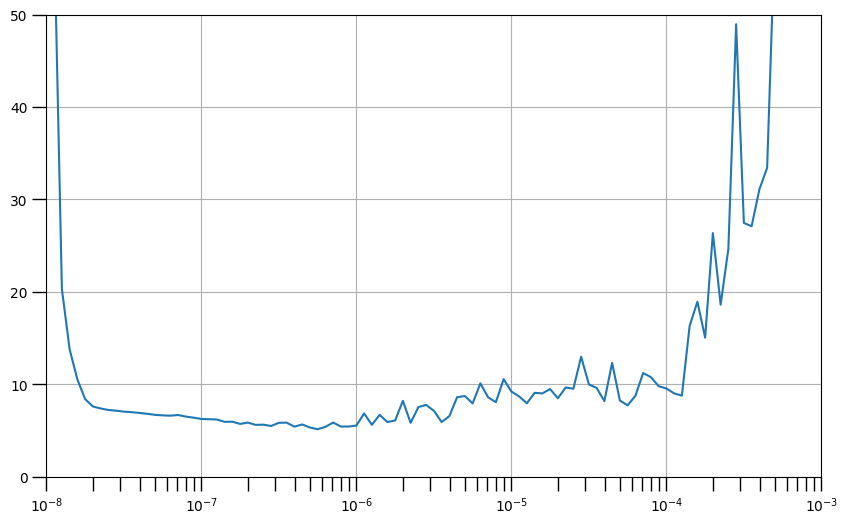

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

## Train the Model

To reset the weights, you can simply call the [`set_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#set_weights) and pass in the saved weights from earlier.

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

Then you can set the training parameters and start training.

In [13]:
# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [14]:
# Train the model
history = model.fit(train_set,epochs=500)

Epoch 1/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 87.8396 - mae: 88.3375
Epoch 2/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4284 - mae: 9.9174 

2024-07-11 10:09:59.398428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9345 - mae: 9.4215
Epoch 3/500
24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2759 - mae: 7.7627

2024-07-11 10:09:59.751492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2356 - mae: 7.7203
Epoch 4/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1554 - mae: 7.6353

2024-07-11 10:10:00.161803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1106 - mae: 7.5932
Epoch 5/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5447 - mae: 8.0301

2024-07-11 10:10:00.527909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1357 - mae: 7.6187
Epoch 6/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4945 - mae: 6.9815

2024-07-11 10:10:00.893032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5242 - mae: 7.0069
Epoch 7/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4070 - mae: 7.8846

2024-07-11 10:10:01.257743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1350 - mae: 7.6143
Epoch 8/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9017 - mae: 7.3757

2024-07-11 10:10:01.621988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5163 - mae: 6.9942
Epoch 9/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.1761 - mae: 6.6577

2024-07-11 10:10:01.988259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3144 - mae: 6.7959
Epoch 10/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7635 - mae: 7.2439

2024-07-11 10:10:02.377736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3464 - mae: 6.8254
Epoch 11/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4328 - mae: 6.9217

2024-07-11 10:10:02.742518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2890 - mae: 6.7758
Epoch 12/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7780 - mae: 6.2566

2024-07-11 10:10:03.108490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8639 - mae: 6.3427
Epoch 13/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3831 - mae: 6.8659

2024-07-11 10:10:03.478720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1757 - mae: 6.6575
Epoch 14/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9474 - mae: 6.4334

2024-07-11 10:10:03.843495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0507 - mae: 6.5358
Epoch 15/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7617 - mae: 6.2442

2024-07-11 10:10:04.208465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7738 - mae: 6.2554
Epoch 16/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1625 - mae: 6.6402

2024-07-11 10:10:04.596288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9845 - mae: 6.4617
Epoch 17/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7834 - mae: 6.2653

2024-07-11 10:10:04.964277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7213 - mae: 6.2025
Epoch 18/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3084 - mae: 6.7845

2024-07-11 10:10:05.328401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8893 - mae: 6.3685
Epoch 19/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7441 - mae: 6.2234

2024-07-11 10:10:05.741453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6404 - mae: 6.1216
Epoch 20/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5260 - mae: 6.0040

2024-07-11 10:10:06.107030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6155 - mae: 6.0941
Epoch 21/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9224 - mae: 5.4032

2024-07-11 10:10:06.467491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1657 - mae: 5.6453
Epoch 22/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5859 - mae: 6.0675

2024-07-11 10:10:06.830768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5155 - mae: 5.9955
Epoch 23/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9169 - mae: 5.3925

2024-07-11 10:10:07.211833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1131 - mae: 5.5912
Epoch 24/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1352 - mae: 5.6174

2024-07-11 10:10:07.576104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2014 - mae: 5.6817
Epoch 25/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6018 - mae: 6.0730

2024-07-11 10:10:07.938540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4800 - mae: 5.9542
Epoch 26/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3091 - mae: 5.7860

2024-07-11 10:10:08.302918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2115 - mae: 5.6883
Epoch 27/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7361 - mae: 5.2164

2024-07-11 10:10:08.674443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1315 - mae: 5.6121
Epoch 28/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2650 - mae: 5.7362

2024-07-11 10:10:09.043291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2445 - mae: 5.7192
Epoch 29/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5382 - mae: 6.0036

2024-07-11 10:10:09.404343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3851 - mae: 5.8571
Epoch 30/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8197 - mae: 5.2880

2024-07-11 10:10:09.779058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9647 - mae: 5.4375
Epoch 31/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2504 - mae: 5.7222

2024-07-11 10:10:10.142392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2402 - mae: 5.7143
Epoch 32/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5309 - mae: 6.0202

2024-07-11 10:10:10.505074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4454 - mae: 5.9306
Epoch 33/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1277 - mae: 5.5999

2024-07-11 10:10:10.885774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0800 - mae: 5.5563
Epoch 34/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9655 - mae: 5.4339

2024-07-11 10:10:11.252213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9944 - mae: 5.4666
Epoch 35/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0608 - mae: 5.5421

2024-07-11 10:10:11.613751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1130 - mae: 5.5945
Epoch 36/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0222 - mae: 5.5032

2024-07-11 10:10:11.977153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0435 - mae: 5.5246
Epoch 37/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2397 - mae: 4.7175

2024-07-11 10:10:12.357052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5534 - mae: 5.0314
Epoch 38/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6613 - mae: 5.1304

2024-07-11 10:10:12.717599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7878 - mae: 5.2611
Epoch 39/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0945 - mae: 5.5625

2024-07-11 10:10:13.081935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0600 - mae: 5.5315
Epoch 40/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3121 - mae: 5.7893

2024-07-11 10:10:13.444797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1997 - mae: 5.6759
Epoch 41/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8593 - mae: 5.3455

2024-07-11 10:10:13.806874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9810 - mae: 5.4646
Epoch 42/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7757 - mae: 5.2502

2024-07-11 10:10:14.171716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8178 - mae: 5.2921
Epoch 43/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4522 - mae: 5.9263

2024-07-11 10:10:14.532278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2601 - mae: 5.7356
Epoch 44/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8194 - mae: 5.2861

2024-07-11 10:10:14.900079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8639 - mae: 5.3326
Epoch 45/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7160 - mae: 5.1901

2024-07-11 10:10:15.263407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8496 - mae: 5.3242
Epoch 46/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7823 - mae: 5.2586

2024-07-11 10:10:15.626553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9537 - mae: 5.4292
Epoch 47/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1434 - mae: 5.6269

2024-07-11 10:10:15.989848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0359 - mae: 5.5167
Epoch 48/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8498 - mae: 5.3276

2024-07-11 10:10:16.354268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8426 - mae: 5.3208
Epoch 49/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7193 - mae: 5.1932

2024-07-11 10:10:16.719653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7922 - mae: 5.2659
Epoch 50/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2430 - mae: 5.7249

2024-07-11 10:10:17.091850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1779 - mae: 5.6579
Epoch 51/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0574 - mae: 5.5279

2024-07-11 10:10:17.478582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9904 - mae: 5.4664
Epoch 52/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7503 - mae: 5.2208

2024-07-11 10:10:17.845580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8074 - mae: 5.2798
Epoch 53/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9461 - mae: 5.4267

2024-07-11 10:10:18.210210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9671 - mae: 5.4454
Epoch 54/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3354 - mae: 5.8155

2024-07-11 10:10:18.575295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0243 - mae: 5.5031
Epoch 55/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6660 - mae: 5.1386

2024-07-11 10:10:18.940055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7814 - mae: 5.2564
Epoch 56/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9869 - mae: 5.4643

2024-07-11 10:10:19.304031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8885 - mae: 5.3659
Epoch 57/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2277 - mae: 5.7100

2024-07-11 10:10:19.670443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0554 - mae: 5.5348
Epoch 58/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5550 - mae: 5.0295

2024-07-11 10:10:20.036507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7399 - mae: 5.2168
Epoch 59/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4334 - mae: 4.9081

2024-07-11 10:10:20.400884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5293 - mae: 5.0025
Epoch 60/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0657 - mae: 5.5414

2024-07-11 10:10:20.767340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9862 - mae: 5.4607
Epoch 61/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9833 - mae: 5.4701

2024-07-11 10:10:21.131808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9211 - mae: 5.4049
Epoch 62/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5305 - mae: 5.0109

2024-07-11 10:10:21.494505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6558 - mae: 5.1347
Epoch 63/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1581 - mae: 5.6347

2024-07-11 10:10:21.864904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0793 - mae: 5.5564
Epoch 64/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8438 - mae: 5.3260

2024-07-11 10:10:22.249898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9698 - mae: 5.4510
Epoch 65/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9615 - mae: 5.4371

2024-07-11 10:10:22.616849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8241 - mae: 5.2996
Epoch 66/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8860 - mae: 5.3569

2024-07-11 10:10:22.981597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0300 - mae: 5.5056
Epoch 67/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9372 - mae: 5.4196

2024-07-11 10:10:23.347943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8185 - mae: 5.2988
Epoch 68/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9400 - mae: 5.4183

2024-07-11 10:10:23.714469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8845 - mae: 5.3625
Epoch 69/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6091 - mae: 5.0795

2024-07-11 10:10:24.112149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6608 - mae: 5.1338
Epoch 70/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7592 - mae: 5.2327

2024-07-11 10:10:24.478681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7957 - mae: 5.2710
Epoch 71/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6117 - mae: 6.0873

2024-07-11 10:10:24.851234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9778 - mae: 5.4530
Epoch 72/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2742 - mae: 4.7351

2024-07-11 10:10:25.218719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5348 - mae: 5.0043
Epoch 73/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2049 - mae: 5.6898

2024-07-11 10:10:25.584767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9356 - mae: 5.4155
Epoch 74/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1201 - mae: 5.6004

2024-07-11 10:10:25.950452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8856 - mae: 5.3643
Epoch 75/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1299 - mae: 4.6015

2024-07-11 10:10:26.319057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4808 - mae: 4.9540
Epoch 76/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8105 - mae: 6.2916

2024-07-11 10:10:26.685826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2958 - mae: 5.7730
Epoch 77/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0462 - mae: 5.5236

2024-07-11 10:10:27.053925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8837 - mae: 5.3611
Epoch 78/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4294 - mae: 5.9019

2024-07-11 10:10:27.429117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0722 - mae: 5.5476
Epoch 79/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3533 - mae: 4.8301

2024-07-11 10:10:27.795456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5670 - mae: 5.0439
Epoch 80/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4486 - mae: 5.9301

2024-07-11 10:10:28.161943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8811 - mae: 5.3603
Epoch 81/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5008 - mae: 4.9680

2024-07-11 10:10:28.529225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5884 - mae: 5.0597
Epoch 82/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4178 - mae: 4.8870

2024-07-11 10:10:28.894484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5329 - mae: 5.0041
Epoch 83/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6902 - mae: 5.1673

2024-07-11 10:10:29.267646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6927 - mae: 5.1678
Epoch 84/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1672 - mae: 4.6413

2024-07-11 10:10:29.632784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3784 - mae: 4.8536
Epoch 85/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6623 - mae: 5.1404

2024-07-11 10:10:30.006708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6211 - mae: 5.0974
Epoch 86/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0289 - mae: 5.5099

2024-07-11 10:10:30.372481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9348 - mae: 5.4148
Epoch 87/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9598 - mae: 5.4347

2024-07-11 10:10:30.739071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7086 - mae: 5.1855
Epoch 88/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0228 - mae: 4.4898

2024-07-11 10:10:31.107752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4327 - mae: 4.9056
Epoch 89/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0887 - mae: 5.5659

2024-07-11 10:10:31.473875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9587 - mae: 5.4339
Epoch 90/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5263 - mae: 5.0055

2024-07-11 10:10:31.837843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6020 - mae: 5.0786
Epoch 91/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2809 - mae: 4.7587

2024-07-11 10:10:32.219930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4938 - mae: 4.9700
Epoch 92/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6150 - mae: 5.0946

2024-07-11 10:10:32.589324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7082 - mae: 5.1891
Epoch 93/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6335 - mae: 6.1155

2024-07-11 10:10:32.954957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1221 - mae: 5.6018
Epoch 94/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5470 - mae: 5.0260

2024-07-11 10:10:33.323387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5779 - mae: 5.0554
Epoch 95/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9785 - mae: 5.4532

2024-07-11 10:10:33.689394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8579 - mae: 5.3354
Epoch 96/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0390 - mae: 5.5173

2024-07-11 10:10:34.055945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8375 - mae: 5.3157
Epoch 97/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6886 - mae: 5.1597

2024-07-11 10:10:34.423022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7835 - mae: 5.2565
Epoch 98/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5322 - mae: 6.0149

2024-07-11 10:10:34.790313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9263 - mae: 5.4063
Epoch 99/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8642 - mae: 5.3338

2024-07-11 10:10:35.168623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8530 - mae: 5.3266
Epoch 100/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3932 - mae: 4.8737

2024-07-11 10:10:35.537728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5398 - mae: 5.0197
Epoch 101/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8479 - mae: 5.3223

2024-07-11 10:10:35.905884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7283 - mae: 5.2037
Epoch 102/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8946 - mae: 4.3666

2024-07-11 10:10:36.272891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2983 - mae: 4.7724
Epoch 103/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8002 - mae: 5.2775

2024-07-11 10:10:36.641849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7273 - mae: 5.2055
Epoch 104/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8674 - mae: 6.3521

2024-07-11 10:10:37.010901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1551 - mae: 5.6344
Epoch 105/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3716 - mae: 4.8422

2024-07-11 10:10:37.391872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4382 - mae: 4.9109
Epoch 106/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9120 - mae: 5.3874

2024-07-11 10:10:37.759802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6846 - mae: 5.1618
Epoch 107/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9061 - mae: 5.3854

2024-07-11 10:10:38.128046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6580 - mae: 5.1362
Epoch 108/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9670 - mae: 5.4497

2024-07-11 10:10:38.495790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7278 - mae: 5.2079
Epoch 109/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9578 - mae: 4.4393

2024-07-11 10:10:38.862668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2534 - mae: 4.7314
Epoch 110/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4488 - mae: 4.9252

2024-07-11 10:10:39.233491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4967 - mae: 4.9734
Epoch 111/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4180 - mae: 4.8751

2024-07-11 10:10:39.616003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4366 - mae: 4.9026
Epoch 112/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4422 - mae: 4.9209

2024-07-11 10:10:39.995014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4871 - mae: 4.9665
Epoch 113/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0003 - mae: 5.4868

2024-07-11 10:10:40.367906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8030 - mae: 5.2844
Epoch 114/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8149 - mae: 5.2876

2024-07-11 10:10:40.737020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6537 - mae: 5.1289
Epoch 115/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2279 - mae: 4.7136

2024-07-11 10:10:41.104685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5713 - mae: 5.0529
Epoch 116/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6498 - mae: 5.1203

2024-07-11 10:10:41.473846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5929 - mae: 5.0649
Epoch 117/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7017 - mae: 5.1827

2024-07-11 10:10:41.845645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6574 - mae: 5.1363
Epoch 118/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4268 - mae: 4.8970

2024-07-11 10:10:42.233504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5165 - mae: 4.9874
Epoch 119/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6497 - mae: 5.1292

2024-07-11 10:10:42.605154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6335 - mae: 5.1112
Epoch 120/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9700 - mae: 5.4442

2024-07-11 10:10:42.981820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6396 - mae: 5.1167
Epoch 121/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0801 - mae: 5.5600

2024-07-11 10:10:43.351006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8938 - mae: 5.3737
Epoch 122/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4131 - mae: 4.8938

2024-07-11 10:10:43.720974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4203 - mae: 4.8994
Epoch 123/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3035 - mae: 4.7728

2024-07-11 10:10:44.096497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3977 - mae: 4.8718
Epoch 124/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2383 - mae: 4.7087

2024-07-11 10:10:44.466349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5068 - mae: 4.9825
Epoch 125/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8063 - mae: 5.2832

2024-07-11 10:10:44.834826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6183 - mae: 5.0933
Epoch 126/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3776 - mae: 4.8491

2024-07-11 10:10:45.221054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4796 - mae: 4.9549
Epoch 127/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8613 - mae: 5.3418

2024-07-11 10:10:45.592053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6742 - mae: 5.1545
Epoch 128/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4661 - mae: 4.9455

2024-07-11 10:10:45.962499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5313 - mae: 5.0099
Epoch 129/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7515 - mae: 5.2284

2024-07-11 10:10:46.333963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5793 - mae: 5.0565
Epoch 130/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1908 - mae: 4.6627

2024-07-11 10:10:46.703618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3564 - mae: 4.8309
Epoch 131/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5267 - mae: 5.0045

2024-07-11 10:10:47.077599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5774 - mae: 5.0537
Epoch 132/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4970 - mae: 4.9770

2024-07-11 10:10:47.453689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4394 - mae: 4.9181
Epoch 133/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3676 - mae: 4.8416

2024-07-11 10:10:47.823710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5074 - mae: 4.9829
Epoch 134/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7800 - mae: 5.2619

2024-07-11 10:10:48.195883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6095 - mae: 5.0873
Epoch 135/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5494 - mae: 5.0231

2024-07-11 10:10:48.563905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5665 - mae: 5.0416
Epoch 136/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1152 - mae: 5.5857

2024-07-11 10:10:48.932592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7170 - mae: 5.1921
Epoch 137/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4734 - mae: 4.9461

2024-07-11 10:10:49.303678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5593 - mae: 5.0330
Epoch 138/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5811 - mae: 5.0504

2024-07-11 10:10:49.672080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5572 - mae: 5.0277
Epoch 139/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1811 - mae: 4.6458

2024-07-11 10:10:50.040983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3556 - mae: 4.8280
Epoch 140/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3273 - mae: 4.8009

2024-07-11 10:10:50.418944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4575 - mae: 4.9328
Epoch 141/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4711 - mae: 4.9386

2024-07-11 10:10:50.790145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5174 - mae: 4.9904
Epoch 142/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9195 - mae: 5.3944

2024-07-11 10:10:51.158261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7143 - mae: 5.1901
Epoch 143/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3137 - mae: 4.7921

2024-07-11 10:10:51.549062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4033 - mae: 4.8813
Epoch 144/500
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3485 - mae: 4.8231

2024-07-11 10:10:51.942531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4149 - mae: 4.8907
Epoch 145/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1811 - mae: 4.6511

2024-07-11 10:10:52.341481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3517 - mae: 4.8232
Epoch 146/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7269 - mae: 5.2081

2024-07-11 10:10:52.721014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5558 - mae: 5.0342
Epoch 147/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5264 - mae: 5.0081

2024-07-11 10:10:53.101693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5905 - mae: 5.0711
Epoch 148/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4512 - mae: 4.9220

2024-07-11 10:10:53.481692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5017 - mae: 4.9742
Epoch 149/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3837 - mae: 4.8587

2024-07-11 10:10:53.857924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4205 - mae: 4.8964
Epoch 150/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8532 - mae: 4.3208

2024-07-11 10:10:54.230440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2000 - mae: 4.6710
Epoch 151/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9600 - mae: 4.4338

2024-07-11 10:10:54.599304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3067 - mae: 4.7831
Epoch 152/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3354 - mae: 4.8170

2024-07-11 10:10:54.966255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3779 - mae: 4.8551
Epoch 153/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0483 - mae: 4.5206

2024-07-11 10:10:55.340957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3464 - mae: 4.8175
Epoch 154/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1015 - mae: 4.5659

2024-07-11 10:10:55.711622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3789 - mae: 4.8494
Epoch 155/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5514 - mae: 5.0306

2024-07-11 10:10:56.078072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5195 - mae: 5.0004
Epoch 156/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6349 - mae: 5.1080

2024-07-11 10:10:56.446234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5668 - mae: 5.0406
Epoch 157/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4706 - mae: 4.9483

2024-07-11 10:10:56.815924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5233 - mae: 4.9991
Epoch 158/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6813 - mae: 5.1591

2024-07-11 10:10:57.195996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6049 - mae: 5.0839
Epoch 159/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7103 - mae: 5.1837

2024-07-11 10:10:57.565488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6154 - mae: 5.0909
Epoch 160/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0241 - mae: 5.5043

2024-07-11 10:10:57.933491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7918 - mae: 5.2704
Epoch 161/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2720 - mae: 4.7464

2024-07-11 10:10:58.305753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3461 - mae: 4.8217
Epoch 162/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7608 - mae: 4.2424

2024-07-11 10:10:58.674901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2513 - mae: 4.7300
Epoch 163/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5171 - mae: 5.0005

2024-07-11 10:10:59.043549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5347 - mae: 5.0139
Epoch 164/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0328 - mae: 5.5135

2024-07-11 10:10:59.411699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6644 - mae: 5.1408
Epoch 165/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3111 - mae: 4.7839

2024-07-11 10:10:59.780541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2955 - mae: 4.7701
Epoch 166/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7193 - mae: 5.2060

2024-07-11 10:11:00.182248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6784 - mae: 5.1620
Epoch 167/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6513 - mae: 5.1242

2024-07-11 10:11:00.572987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5558 - mae: 5.0300
Epoch 168/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5660 - mae: 5.0348

2024-07-11 10:11:00.937508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5433 - mae: 5.0151
Epoch 169/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2621 - mae: 4.7419

2024-07-11 10:11:01.306121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3403 - mae: 4.8203
Epoch 170/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5042 - mae: 4.9881

2024-07-11 10:11:01.671730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4663 - mae: 4.9466
Epoch 171/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3467 - mae: 4.8123

2024-07-11 10:11:02.040276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4442 - mae: 4.9136
Epoch 172/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3000 - mae: 4.7721

2024-07-11 10:11:02.420169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3741 - mae: 4.8483
Epoch 173/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1775 - mae: 4.6597

2024-07-11 10:11:02.791817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3797 - mae: 4.8557
Epoch 174/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2529 - mae: 4.7288

2024-07-11 10:11:03.161324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4522 - mae: 4.9296
Epoch 175/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5906 - mae: 5.0752

2024-07-11 10:11:03.530906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5966 - mae: 5.0774
Epoch 176/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6180 - mae: 5.0922

2024-07-11 10:11:03.899725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5718 - mae: 5.0496
Epoch 177/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3293 - mae: 4.8022

2024-07-11 10:11:04.267898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3763 - mae: 4.8489
Epoch 178/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2154 - mae: 4.6895

2024-07-11 10:11:04.637612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4050 - mae: 4.8823
Epoch 179/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8332 - mae: 4.3103

2024-07-11 10:11:05.008161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2759 - mae: 4.7519
Epoch 180/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8962 - mae: 5.3784

2024-07-11 10:11:05.384353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5982 - mae: 5.0764
Epoch 181/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8301 - mae: 5.3099

2024-07-11 10:11:05.754858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6760 - mae: 5.1534
Epoch 182/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8870 - mae: 4.3609

2024-07-11 10:11:06.127904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0957 - mae: 4.5714
Epoch 183/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6796 - mae: 5.1579

2024-07-11 10:11:06.499077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4848 - mae: 4.9620
Epoch 184/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1937 - mae: 4.6737

2024-07-11 10:11:06.869161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3838 - mae: 4.8629
Epoch 185/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0607 - mae: 4.5356

2024-07-11 10:11:07.258225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2125 - mae: 4.6875
Epoch 186/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6260 - mae: 5.1045

2024-07-11 10:11:07.630200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5400 - mae: 5.0203
Epoch 187/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9485 - mae: 5.4344

2024-07-11 10:11:08.000170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7306 - mae: 5.2106
Epoch 188/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4967 - mae: 4.9818

2024-07-11 10:11:08.370744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5181 - mae: 5.0000
Epoch 189/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6892 - mae: 5.1676

2024-07-11 10:11:08.745062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6889 - mae: 5.1684
Epoch 190/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2131 - mae: 4.6802

2024-07-11 10:11:09.115710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3178 - mae: 4.7917
Epoch 191/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2854 - mae: 4.7518

2024-07-11 10:11:09.484748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3310 - mae: 4.8032
Epoch 192/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9411 - mae: 5.4101

2024-07-11 10:11:09.853449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5674 - mae: 5.0391
Epoch 193/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5410 - mae: 5.0159

2024-07-11 10:11:10.220828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5778 - mae: 5.0542
Epoch 194/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0159 - mae: 4.4872

2024-07-11 10:11:10.600927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2556 - mae: 4.7310
Epoch 195/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5572 - mae: 5.0344

2024-07-11 10:11:10.971466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4597 - mae: 4.9378
Epoch 196/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4138 - mae: 4.9009

2024-07-11 10:11:11.342318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4194 - mae: 4.9006
Epoch 197/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6935 - mae: 5.1755

2024-07-11 10:11:11.711339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6429 - mae: 5.1232
Epoch 198/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3507 - mae: 4.8370

2024-07-11 10:11:12.085616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3160 - mae: 4.7989
Epoch 199/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3663 - mae: 4.8440

2024-07-11 10:11:12.469844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3752 - mae: 4.8496
Epoch 200/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2332 - mae: 4.7044

2024-07-11 10:11:12.840842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2995 - mae: 4.7738
Epoch 201/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4447 - mae: 4.9323

2024-07-11 10:11:13.210011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4465 - mae: 4.9290
Epoch 202/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2369 - mae: 4.7108

2024-07-11 10:11:13.580679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2687 - mae: 4.7416
Epoch 203/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3032 - mae: 4.7735

2024-07-11 10:11:13.952185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3578 - mae: 4.8312
Epoch 204/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2434 - mae: 4.7231

2024-07-11 10:11:14.321353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2659 - mae: 4.7450
Epoch 205/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9556 - mae: 4.4368

2024-07-11 10:11:14.686321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1406 - mae: 4.6200
Epoch 206/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5848 - mae: 5.0564

2024-07-11 10:11:15.055899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5807 - mae: 5.0550
Epoch 207/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6708 - mae: 5.1361

2024-07-11 10:11:15.424964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6483 - mae: 5.1187
Epoch 208/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6204 - mae: 5.0935

2024-07-11 10:11:15.803797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4495 - mae: 4.9249
Epoch 209/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9134 - mae: 4.3843

2024-07-11 10:11:16.173784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1021 - mae: 4.5735
Epoch 210/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4492 - mae: 4.9228

2024-07-11 10:11:16.566022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4258 - mae: 4.9005
Epoch 211/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4805 - mae: 4.9576

2024-07-11 10:11:16.945639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3153 - mae: 4.7895
Epoch 212/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4557 - mae: 4.9362

2024-07-11 10:11:17.354534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4963 - mae: 4.9769
Epoch 213/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0924 - mae: 4.5540

2024-07-11 10:11:17.727136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3106 - mae: 4.7815
Epoch 214/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9746 - mae: 5.4632

2024-07-11 10:11:18.109277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7012 - mae: 5.1842
Epoch 215/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8170 - mae: 5.2936

2024-07-11 10:11:18.478847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6749 - mae: 5.1525
Epoch 216/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2954 - mae: 4.7680

2024-07-11 10:11:18.848113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3357 - mae: 4.8082
Epoch 217/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3643 - mae: 4.8293

2024-07-11 10:11:19.220866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3583 - mae: 4.8283
Epoch 218/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9060 - mae: 5.3849

2024-07-11 10:11:19.590867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6859 - mae: 5.1656
Epoch 219/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6112 - mae: 5.0906

2024-07-11 10:11:19.959948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5280 - mae: 5.0054
Epoch 220/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2687 - mae: 4.7373

2024-07-11 10:11:20.420010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3261 - mae: 4.7980
Epoch 221/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8648 - mae: 4.3416

2024-07-11 10:11:20.797943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1617 - mae: 4.6380
Epoch 222/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4159 - mae: 4.9016

2024-07-11 10:11:21.167728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4151 - mae: 4.8993
Epoch 223/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5087 - mae: 4.9928

2024-07-11 10:11:21.533941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4143 - mae: 4.8954
Epoch 224/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0942 - mae: 4.5668

2024-07-11 10:11:21.902362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3401 - mae: 4.8170
Epoch 225/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5991 - mae: 5.0784

2024-07-11 10:11:22.287271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4414 - mae: 4.9175
Epoch 226/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1990 - mae: 4.6706

2024-07-11 10:11:22.655967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2218 - mae: 4.6939
Epoch 227/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6228 - mae: 5.1029

2024-07-11 10:11:23.021301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6803 - mae: 5.1612
Epoch 228/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0411 - mae: 4.5175

2024-07-11 10:11:23.387633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2591 - mae: 4.7342
Epoch 229/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7996 - mae: 5.2700

2024-07-11 10:11:23.754473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6757 - mae: 5.1499
Epoch 230/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0024 - mae: 4.4869

2024-07-11 10:11:24.122649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2046 - mae: 4.6858
Epoch 231/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7666 - mae: 5.2434

2024-07-11 10:11:24.491235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5283 - mae: 5.0055
Epoch 232/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2565 - mae: 4.7262

2024-07-11 10:11:24.858854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3218 - mae: 4.7937
Epoch 233/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2669 - mae: 4.7434

2024-07-11 10:11:25.225261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2633 - mae: 4.7374
Epoch 234/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9362 - mae: 5.4071

2024-07-11 10:11:25.593532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6028 - mae: 5.0770
Epoch 235/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3226 - mae: 4.7972

2024-07-11 10:11:25.968681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3099 - mae: 4.7835
Epoch 236/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2237 - mae: 4.6989

2024-07-11 10:11:26.337211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3171 - mae: 4.7943
Epoch 237/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1645 - mae: 4.6386

2024-07-11 10:11:26.706170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2364 - mae: 4.7094
Epoch 238/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0136 - mae: 5.4924

2024-07-11 10:11:27.078027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8069 - mae: 5.2841
Epoch 239/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9992 - mae: 4.4789

2024-07-11 10:11:27.459869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1892 - mae: 4.6680
Epoch 240/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5867 - mae: 5.0664

2024-07-11 10:11:27.831437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5233 - mae: 5.0011
Epoch 241/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5693 - mae: 5.0428

2024-07-11 10:11:28.200229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3879 - mae: 4.8624
Epoch 242/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3887 - mae: 4.8755

2024-07-11 10:11:28.567357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4114 - mae: 4.8939
Epoch 243/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9130 - mae: 4.3877

2024-07-11 10:11:28.938057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1893 - mae: 4.6665
Epoch 244/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7382 - mae: 5.2110

2024-07-11 10:11:29.308368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4552 - mae: 4.9298
Epoch 245/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9056 - mae: 4.3788

2024-07-11 10:11:29.677688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1174 - mae: 4.5904
Epoch 246/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3880 - mae: 4.8605

2024-07-11 10:11:30.046826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4632 - mae: 4.9376
Epoch 247/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7825 - mae: 4.2548

2024-07-11 10:11:30.415124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1448 - mae: 4.6208
Epoch 248/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8158 - mae: 5.2966

2024-07-11 10:11:30.796999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5834 - mae: 5.0613
Epoch 249/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7594 - mae: 5.2334

2024-07-11 10:11:31.170332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5103 - mae: 4.9851
Epoch 250/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5320 - mae: 5.0000

2024-07-11 10:11:31.540669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4098 - mae: 4.8794
Epoch 251/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9095 - mae: 5.3856

2024-07-11 10:11:31.910599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7052 - mae: 5.1821
Epoch 252/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9949 - mae: 5.4714

2024-07-11 10:11:32.300846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7343 - mae: 5.2088
Epoch 253/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1919 - mae: 4.6680

2024-07-11 10:11:32.735960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3037 - mae: 4.7799
Epoch 254/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4699 - mae: 4.9491

2024-07-11 10:11:33.109157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4130 - mae: 4.8915
Epoch 255/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2474 - mae: 4.7211

2024-07-11 10:11:33.480031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3461 - mae: 4.8204
Epoch 256/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3692 - mae: 4.8502

2024-07-11 10:11:33.848758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3166 - mae: 4.7945
Epoch 257/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1201 - mae: 4.5994

2024-07-11 10:11:34.220825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3009 - mae: 4.7781
Epoch 258/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3661 - mae: 4.8356

2024-07-11 10:11:34.590274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4004 - mae: 4.8735
Epoch 259/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6131 - mae: 5.0838

2024-07-11 10:11:34.961060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4867 - mae: 4.9582
Epoch 260/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7780 - mae: 4.2628

2024-07-11 10:11:35.330734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0483 - mae: 4.5300
Epoch 261/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5979 - mae: 5.0830

2024-07-11 10:11:35.701504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4358 - mae: 4.9172
Epoch 262/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9239 - mae: 4.3967

2024-07-11 10:11:36.075914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1039 - mae: 4.5749
Epoch 263/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2320 - mae: 4.6932

2024-07-11 10:11:36.445599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3132 - mae: 4.7793
Epoch 264/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2200 - mae: 4.7027

2024-07-11 10:11:36.818728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3073 - mae: 4.7864
Epoch 265/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4298 - mae: 4.9087

2024-07-11 10:11:37.203453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3443 - mae: 4.8212
Epoch 266/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4001 - mae: 4.8804

2024-07-11 10:11:37.573091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3014 - mae: 4.7793
Epoch 267/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4267 - mae: 4.8986

2024-07-11 10:11:37.942542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3309 - mae: 4.8019
Epoch 268/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8635 - mae: 4.3490

2024-07-11 10:11:38.312950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1526 - mae: 4.6316
Epoch 269/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4581 - mae: 4.9367

2024-07-11 10:11:38.683230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4308 - mae: 4.9079
Epoch 270/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4334 - mae: 4.9154

2024-07-11 10:11:39.050508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4187 - mae: 4.8974
Epoch 271/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9391 - mae: 4.4117

2024-07-11 10:11:39.423626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1289 - mae: 4.6020
Epoch 272/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3441 - mae: 4.8197

2024-07-11 10:11:39.792832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2967 - mae: 4.7689
Epoch 273/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1436 - mae: 4.6274

2024-07-11 10:11:40.160307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2894 - mae: 4.7671
Epoch 274/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5364 - mae: 5.0114

2024-07-11 10:11:40.531257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3992 - mae: 4.8723
Epoch 275/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9929 - mae: 4.4705

2024-07-11 10:11:40.908398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2572 - mae: 4.7352
Epoch 276/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2789 - mae: 4.7531

2024-07-11 10:11:41.278449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3148 - mae: 4.7894
Epoch 277/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0918 - mae: 5.5782

2024-07-11 10:11:41.648951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7082 - mae: 5.1909
Epoch 278/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6921 - mae: 5.1685

2024-07-11 10:11:42.018653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5213 - mae: 4.9974
Epoch 279/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2275 - mae: 4.7062

2024-07-11 10:11:42.428249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2576 - mae: 4.7335
Epoch 280/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6207 - mae: 5.1062

2024-07-11 10:11:42.817628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3918 - mae: 4.8699
Epoch 281/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6254 - mae: 5.0905

2024-07-11 10:11:43.224288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4779 - mae: 4.9503
Epoch 282/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3972 - mae: 4.8701

2024-07-11 10:11:43.634095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3054 - mae: 4.7795
Epoch 283/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5196 - mae: 5.0046

2024-07-11 10:11:44.019433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3736 - mae: 4.8539
Epoch 284/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2200 - mae: 4.7007

2024-07-11 10:11:44.391849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2935 - mae: 4.7692
Epoch 285/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8361 - mae: 5.3151

2024-07-11 10:11:44.798490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6204 - mae: 5.0972
Epoch 286/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0220 - mae: 4.4909

2024-07-11 10:11:45.227842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1293 - mae: 4.6013
Epoch 287/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1020 - mae: 4.5707

2024-07-11 10:11:45.598745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2410 - mae: 4.7119
Epoch 288/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1678 - mae: 4.6459

2024-07-11 10:11:45.976747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1962 - mae: 4.6689
Epoch 289/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3150 - mae: 4.7934

2024-07-11 10:11:46.349722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2129 - mae: 4.6897
Epoch 290/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2496 - mae: 4.7227

2024-07-11 10:11:46.725753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2870 - mae: 4.7596
Epoch 291/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9680 - mae: 5.4506

2024-07-11 10:11:47.109298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5066 - mae: 4.9817
Epoch 292/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1995 - mae: 4.6725

2024-07-11 10:11:47.482145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2795 - mae: 4.7532
Epoch 293/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0344 - mae: 4.5075

2024-07-11 10:11:47.851150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1301 - mae: 4.6044
Epoch 294/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7538 - mae: 4.2198

2024-07-11 10:11:48.227835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0307 - mae: 4.5042
Epoch 295/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8881 - mae: 5.3631

2024-07-11 10:11:48.597417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5096 - mae: 4.9847
Epoch 296/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7857 - mae: 5.2646

2024-07-11 10:11:48.966108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4820 - mae: 4.9582
Epoch 297/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9904 - mae: 4.4685

2024-07-11 10:11:49.337429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3040 - mae: 4.7819
Epoch 298/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3304 - mae: 4.7983

2024-07-11 10:11:49.707072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3146 - mae: 4.7857
Epoch 299/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6688 - mae: 5.1372

2024-07-11 10:11:50.077545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3983 - mae: 4.8675
Epoch 300/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4426 - mae: 4.9241

2024-07-11 10:11:50.445566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4032 - mae: 4.8825
Epoch 301/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6187 - mae: 5.1022

2024-07-11 10:11:50.815310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5100 - mae: 4.9940
Epoch 302/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4973 - mae: 4.9598

2024-07-11 10:11:51.194555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3855 - mae: 4.8522
Epoch 303/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9458 - mae: 4.4198

2024-07-11 10:11:51.564701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0779 - mae: 4.5518
Epoch 304/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2606 - mae: 4.7386

2024-07-11 10:11:51.948838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2853 - mae: 4.7621
Epoch 305/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6785 - mae: 5.1530

2024-07-11 10:11:52.335267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4227 - mae: 4.8978
Epoch 306/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7397 - mae: 4.2132

2024-07-11 10:11:52.703372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9863 - mae: 4.4595
Epoch 307/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1318 - mae: 4.5989

2024-07-11 10:11:53.071925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2633 - mae: 4.7347
Epoch 308/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2418 - mae: 4.7171

2024-07-11 10:11:53.440061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2773 - mae: 4.7531
Epoch 309/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2495 - mae: 4.7322

2024-07-11 10:11:53.809428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3293 - mae: 4.8086
Epoch 310/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2492 - mae: 4.7193

2024-07-11 10:11:54.181102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2404 - mae: 4.7132
Epoch 311/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1044 - mae: 4.5796

2024-07-11 10:11:54.552969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2446 - mae: 4.7200
Epoch 312/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4365 - mae: 4.9137

2024-07-11 10:11:54.924634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3421 - mae: 4.8176
Epoch 313/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2753 - mae: 4.7485

2024-07-11 10:11:55.293579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3393 - mae: 4.8126
Epoch 314/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5115 - mae: 4.9757

2024-07-11 10:11:55.685607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4962 - mae: 4.9664
Epoch 315/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9592 - mae: 5.4437

2024-07-11 10:11:56.055110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6940 - mae: 5.1734
Epoch 316/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9355 - mae: 4.4057

2024-07-11 10:11:56.425153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1008 - mae: 4.5727
Epoch 317/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9598 - mae: 4.4383

2024-07-11 10:11:56.793879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2281 - mae: 4.7075
Epoch 318/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2847 - mae: 4.7654

2024-07-11 10:11:57.176225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2549 - mae: 4.7336
Epoch 319/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9001 - mae: 5.3875

2024-07-11 10:11:57.548974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5405 - mae: 5.0200
Epoch 320/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3745 - mae: 4.8555

2024-07-11 10:11:57.921444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3256 - mae: 4.8032
Epoch 321/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0890 - mae: 4.5608

2024-07-11 10:11:58.290073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2078 - mae: 4.6817
Epoch 322/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4024 - mae: 4.8771

2024-07-11 10:11:58.659235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3348 - mae: 4.8099
Epoch 323/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0494 - mae: 4.5243

2024-07-11 10:11:59.028791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1764 - mae: 4.6522
Epoch 324/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9786 - mae: 4.4504

2024-07-11 10:11:59.398723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0121 - mae: 4.4845
Epoch 325/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1133 - mae: 4.5973

2024-07-11 10:11:59.771081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3961 - mae: 4.8763
Epoch 326/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9372 - mae: 4.3979

2024-07-11 10:12:00.138849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0525 - mae: 4.5195
Epoch 327/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3718 - mae: 4.8512

2024-07-11 10:12:00.507068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2460 - mae: 4.7213
Epoch 328/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3235 - mae: 4.7950

2024-07-11 10:12:00.875522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2974 - mae: 4.7733
Epoch 329/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4740 - mae: 4.9452

2024-07-11 10:12:01.251629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3563 - mae: 4.8270
Epoch 330/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5285 - mae: 5.0091

2024-07-11 10:12:01.621389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3733 - mae: 4.8523
Epoch 331/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5124 - mae: 4.9916

2024-07-11 10:12:01.990580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4245 - mae: 4.9022
Epoch 332/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0539 - mae: 4.5366

2024-07-11 10:12:02.375142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1705 - mae: 4.6518
Epoch 333/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6596 - mae: 4.1260

2024-07-11 10:12:02.743157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9565 - mae: 4.4265
Epoch 334/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5088 - mae: 4.9848

2024-07-11 10:12:03.113744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3736 - mae: 4.8480
Epoch 335/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2067 - mae: 4.6794

2024-07-11 10:12:03.485058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2619 - mae: 4.7355
Epoch 336/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9706 - mae: 5.4413

2024-07-11 10:12:03.853464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5650 - mae: 5.0356
Epoch 337/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9859 - mae: 5.4729

2024-07-11 10:12:04.222011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7478 - mae: 5.2303
Epoch 338/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5233 - mae: 4.9953

2024-07-11 10:12:04.590809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2855 - mae: 4.7571
Epoch 339/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8714 - mae: 5.3470

2024-07-11 10:12:04.960147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6071 - mae: 5.0833
Epoch 340/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3283 - mae: 4.8046

2024-07-11 10:12:05.328030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4313 - mae: 4.9086
Epoch 341/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3552 - mae: 4.8307

2024-07-11 10:12:05.695611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3958 - mae: 4.8701
Epoch 342/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6175 - mae: 5.1031

2024-07-11 10:12:06.065030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4851 - mae: 4.9675
Epoch 343/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1583 - mae: 4.6221

2024-07-11 10:12:06.443847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2734 - mae: 4.7434
Epoch 344/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4124 - mae: 4.8777

2024-07-11 10:12:06.812676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3208 - mae: 4.7887
Epoch 345/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3911 - mae: 4.8605

2024-07-11 10:12:07.198405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4065 - mae: 4.8795
Epoch 346/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1309 - mae: 4.6034

2024-07-11 10:12:07.567596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2530 - mae: 4.7263
Epoch 347/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9904 - mae: 4.4595

2024-07-11 10:12:07.938568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2332 - mae: 4.7063
Epoch 348/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6207 - mae: 5.1014

2024-07-11 10:12:08.309193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4698 - mae: 4.9468
Epoch 349/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3213 - mae: 4.7990

2024-07-11 10:12:08.685185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3418 - mae: 4.8159
Epoch 350/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1592 - mae: 4.6382

2024-07-11 10:12:09.054308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3281 - mae: 4.8054
Epoch 351/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3976 - mae: 4.8702

2024-07-11 10:12:09.423848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2771 - mae: 4.7494
Epoch 352/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2916 - mae: 4.7604

2024-07-11 10:12:09.793127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2475 - mae: 4.7197
Epoch 353/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1305 - mae: 4.5990

2024-07-11 10:12:10.184925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1979 - mae: 4.6667
Epoch 354/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3956 - mae: 4.8697

2024-07-11 10:12:10.555901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3102 - mae: 4.7825
Epoch 355/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7588 - mae: 5.2315

2024-07-11 10:12:10.934852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5212 - mae: 4.9971
Epoch 356/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1960 - mae: 4.6657

2024-07-11 10:12:11.316406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2576 - mae: 4.7298
Epoch 357/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9889 - mae: 4.4528

2024-07-11 10:12:11.688240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0057 - mae: 4.4733
Epoch 358/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3544 - mae: 4.8243

2024-07-11 10:12:12.058911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3100 - mae: 4.7816
Epoch 359/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1055 - mae: 4.5792

2024-07-11 10:12:12.441053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1560 - mae: 4.6293
Epoch 360/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5819 - mae: 5.0636

2024-07-11 10:12:12.811946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4062 - mae: 4.8854
Epoch 361/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2471 - mae: 4.7231

2024-07-11 10:12:13.180502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3179 - mae: 4.7958
Epoch 362/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3309 - mae: 4.8090

2024-07-11 10:12:13.549991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2115 - mae: 4.6879
Epoch 363/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6818 - mae: 4.1455

2024-07-11 10:12:13.920964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9866 - mae: 4.4553
Epoch 364/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1179 - mae: 4.5971

2024-07-11 10:12:14.289859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1452 - mae: 4.6196
Epoch 365/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2076 - mae: 4.6739

2024-07-11 10:12:14.656599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2026 - mae: 4.6738
Epoch 366/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1542 - mae: 4.6271

2024-07-11 10:12:15.025493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2337 - mae: 4.7097
Epoch 367/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3594 - mae: 3.8241

2024-07-11 10:12:15.394704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8441 - mae: 4.3114
Epoch 368/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8679 - mae: 4.3355

2024-07-11 10:12:15.763079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9877 - mae: 4.4566
Epoch 369/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4142 - mae: 4.8942

2024-07-11 10:12:16.131607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3657 - mae: 4.8426
Epoch 370/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3488 - mae: 4.8229

2024-07-11 10:12:16.508634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2704 - mae: 4.7422
Epoch 371/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7533 - mae: 5.2237

2024-07-11 10:12:16.883105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5185 - mae: 4.9908
Epoch 372/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7942 - mae: 4.2644

2024-07-11 10:12:17.280762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9710 - mae: 4.4438
Epoch 373/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7215 - mae: 4.1981

2024-07-11 10:12:17.657614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9664 - mae: 4.4419
Epoch 374/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2174 - mae: 4.6954

2024-07-11 10:12:18.034154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2878 - mae: 4.7661
Epoch 375/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8046 - mae: 4.2653

2024-07-11 10:12:18.416443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0600 - mae: 4.5288
Epoch 376/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3830 - mae: 4.8613

2024-07-11 10:12:18.785200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2322 - mae: 4.7065
Epoch 377/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6773 - mae: 5.1534

2024-07-11 10:12:19.153515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4949 - mae: 4.9699
Epoch 378/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1882 - mae: 4.6633

2024-07-11 10:12:19.522584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2060 - mae: 4.6791
Epoch 379/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7411 - mae: 5.2083

2024-07-11 10:12:19.891980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4300 - mae: 4.9025
Epoch 380/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8067 - mae: 4.2846

2024-07-11 10:12:20.290831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0186 - mae: 4.4964
Epoch 381/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2222 - mae: 4.6947

2024-07-11 10:12:20.659072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1661 - mae: 4.6403
Epoch 382/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2115 - mae: 4.6729

2024-07-11 10:12:21.029351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1198 - mae: 4.5853
Epoch 383/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6522 - mae: 5.1270

2024-07-11 10:12:21.400355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4806 - mae: 4.9559
Epoch 384/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4429 - mae: 4.9131

2024-07-11 10:12:21.770303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3300 - mae: 4.8019
Epoch 385/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0973 - mae: 4.5717

2024-07-11 10:12:22.155352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1326 - mae: 4.6067
Epoch 386/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2726 - mae: 4.7453

2024-07-11 10:12:22.530551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1761 - mae: 4.6510
Epoch 387/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6662 - mae: 5.1366

2024-07-11 10:12:22.899538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4336 - mae: 4.9066
Epoch 388/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3207 - mae: 4.7971

2024-07-11 10:12:23.269206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2691 - mae: 4.7451
Epoch 389/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3980 - mae: 4.8693

2024-07-11 10:12:23.638566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3235 - mae: 4.7955
Epoch 390/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4791 - mae: 4.9537

2024-07-11 10:12:24.011135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3804 - mae: 4.8538
Epoch 391/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4311 - mae: 4.9041

2024-07-11 10:12:24.383888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3536 - mae: 4.8278
Epoch 392/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3300 - mae: 4.7926

2024-07-11 10:12:24.750551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2825 - mae: 4.7464
Epoch 393/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2237 - mae: 4.7009

2024-07-11 10:12:25.122145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2963 - mae: 4.7719
Epoch 394/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0824 - mae: 4.5558

2024-07-11 10:12:25.490063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2292 - mae: 4.7041
Epoch 395/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2921 - mae: 4.7598

2024-07-11 10:12:25.858874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2168 - mae: 4.6869
Epoch 396/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6442 - mae: 4.1105

2024-07-11 10:12:26.228182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9583 - mae: 4.4277
Epoch 397/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2922 - mae: 4.7614

2024-07-11 10:12:26.606484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2816 - mae: 4.7529
Epoch 398/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4817 - mae: 4.9661

2024-07-11 10:12:26.977659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3600 - mae: 4.8406
Epoch 399/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4950 - mae: 4.9692

2024-07-11 10:12:27.368119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3861 - mae: 4.8609
Epoch 400/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0653 - mae: 4.5332

2024-07-11 10:12:27.733904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1728 - mae: 4.6423
Epoch 401/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5017 - mae: 4.9811

2024-07-11 10:12:28.102431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3866 - mae: 4.8647
Epoch 402/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6563 - mae: 5.1300

2024-07-11 10:12:28.466500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3805 - mae: 4.8526
Epoch 403/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1575 - mae: 4.6314

2024-07-11 10:12:28.833203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1878 - mae: 4.6598
Epoch 404/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5651 - mae: 5.0413

2024-07-11 10:12:29.203180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3942 - mae: 4.8679
Epoch 405/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1134 - mae: 4.5981

2024-07-11 10:12:29.571278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2483 - mae: 4.7327
Epoch 406/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5938 - mae: 5.0700

2024-07-11 10:12:29.939731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3808 - mae: 4.8559
Epoch 407/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1940 - mae: 4.6616

2024-07-11 10:12:30.307591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2199 - mae: 4.6908
Epoch 408/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1131 - mae: 4.5746

2024-07-11 10:12:30.677094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2012 - mae: 4.6703
Epoch 409/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6298 - mae: 5.1036

2024-07-11 10:12:31.064466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4176 - mae: 4.8918
Epoch 410/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6889 - mae: 4.1620

2024-07-11 10:12:31.434244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9618 - mae: 4.4346
Epoch 411/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1270 - mae: 4.6096

2024-07-11 10:12:31.813882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2125 - mae: 4.6933
Epoch 412/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1516 - mae: 4.6246

2024-07-11 10:12:32.197434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2280 - mae: 4.7010
Epoch 413/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4048 - mae: 4.8869

2024-07-11 10:12:32.567614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3385 - mae: 4.8200
Epoch 414/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2918 - mae: 4.7703

2024-07-11 10:12:32.936330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2288 - mae: 4.7046
Epoch 415/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5339 - mae: 5.0161

2024-07-11 10:12:33.303583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4718 - mae: 4.9516
Epoch 416/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2230 - mae: 4.6987

2024-07-11 10:12:33.669910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2275 - mae: 4.7020
Epoch 417/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2921 - mae: 4.7626

2024-07-11 10:12:34.036803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3978 - mae: 4.8697
Epoch 418/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2506 - mae: 4.7288

2024-07-11 10:12:34.411679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2637 - mae: 4.7382
Epoch 419/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3701 - mae: 4.8461

2024-07-11 10:12:34.781509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3561 - mae: 4.8298
Epoch 420/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3009 - mae: 4.7696

2024-07-11 10:12:35.152704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2823 - mae: 4.7530
Epoch 421/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1827 - mae: 4.6576

2024-07-11 10:12:35.523921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2007 - mae: 4.6755
Epoch 422/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1800 - mae: 4.6586

2024-07-11 10:12:35.901975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1951 - mae: 4.6698
Epoch 423/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3439 - mae: 4.8156

2024-07-11 10:12:36.288521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4093 - mae: 4.8835
Epoch 424/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1229 - mae: 4.5931

2024-07-11 10:12:36.666887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1339 - mae: 4.6049
Epoch 425/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1902 - mae: 4.6716

2024-07-11 10:12:37.037814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2755 - mae: 4.7544
Epoch 426/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3752 - mae: 4.8451

2024-07-11 10:12:37.425786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3243 - mae: 4.7950
Epoch 427/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8920 - mae: 5.3770

2024-07-11 10:12:37.792803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7126 - mae: 5.1956
Epoch 428/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2347 - mae: 4.7141

2024-07-11 10:12:38.158779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2379 - mae: 4.7156
Epoch 429/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3756 - mae: 4.8562

2024-07-11 10:12:38.538070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2685 - mae: 4.7476
Epoch 430/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4717 - mae: 4.9465

2024-07-11 10:12:38.906636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3849 - mae: 4.8596
Epoch 431/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1214 - mae: 4.5908

2024-07-11 10:12:39.272968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1480 - mae: 4.6218
Epoch 432/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6128 - mae: 5.0826

2024-07-11 10:12:39.641055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3585 - mae: 4.8302
Epoch 433/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3525 - mae: 4.8290

2024-07-11 10:12:40.009135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3616 - mae: 4.8361
Epoch 434/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4696 - mae: 4.9465

2024-07-11 10:12:40.376587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2876 - mae: 4.7633
Epoch 435/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7420 - mae: 4.2173

2024-07-11 10:12:40.745241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0221 - mae: 4.4988
Epoch 436/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8415 - mae: 4.3144

2024-07-11 10:12:41.113468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0525 - mae: 4.5248
Epoch 437/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2960 - mae: 4.7700

2024-07-11 10:12:41.482561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2492 - mae: 4.7224
Epoch 438/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2111 - mae: 4.6846

2024-07-11 10:12:41.860038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2397 - mae: 4.7133
Epoch 439/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4403 - mae: 4.9221

2024-07-11 10:12:42.242759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3508 - mae: 4.8311
Epoch 440/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9505 - mae: 5.4354

2024-07-11 10:12:42.612454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6556 - mae: 5.1365
Epoch 441/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0744 - mae: 4.5528

2024-07-11 10:12:42.981461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1505 - mae: 4.6287
Epoch 442/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1186 - mae: 4.5987

2024-07-11 10:12:43.354262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2248 - mae: 4.7037
Epoch 443/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2261 - mae: 4.7094

2024-07-11 10:12:43.722219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2161 - mae: 4.6954
Epoch 444/500
25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1697 - mae: 4.6411

2024-07-11 10:12:44.091588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1711 - mae: 4.6419
Epoch 445/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1690 - mae: 4.6407

2024-07-11 10:12:44.487304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1714 - mae: 4.6449
Epoch 446/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2825 - mae: 4.7626

2024-07-11 10:12:44.856375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1827 - mae: 4.6605
Epoch 447/500
 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9291 - mae: 5.4019  

2024-07-11 10:12:45.338160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4156 - mae: 4.8920
Epoch 448/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6174 - mae: 5.0956

2024-07-11 10:12:45.855470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5437 - mae: 5.0220
Epoch 449/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9250 - mae: 5.4030

2024-07-11 10:12:46.403253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4603 - mae: 4.9347
Epoch 450/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9974 - mae: 4.4785

2024-07-11 10:12:46.894261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1204 - mae: 4.5998
Epoch 451/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2328 - mae: 4.7030

2024-07-11 10:12:47.331795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1769 - mae: 4.6464
Epoch 452/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1010 - mae: 4.5805

2024-07-11 10:12:47.718333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1580 - mae: 4.6341
Epoch 453/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9394 - mae: 4.4143

2024-07-11 10:12:48.111733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1181 - mae: 4.5927
Epoch 454/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1932 - mae: 4.6606

2024-07-11 10:12:48.487605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2120 - mae: 4.6820
Epoch 455/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2434 - mae: 4.7159

2024-07-11 10:12:48.881458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1745 - mae: 4.6479
Epoch 456/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9151 - mae: 4.3964

2024-07-11 10:12:49.251292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1241 - mae: 4.6020
Epoch 457/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0884 - mae: 4.5708

2024-07-11 10:12:49.623024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2407 - mae: 4.7188
Epoch 458/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0872 - mae: 4.5620

2024-07-11 10:12:49.993208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1533 - mae: 4.6291
Epoch 459/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8105 - mae: 4.2819

2024-07-11 10:12:50.361340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0145 - mae: 4.4864
Epoch 460/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7122 - mae: 5.1911

2024-07-11 10:12:50.730839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5173 - mae: 4.9953
Epoch 461/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0709 - mae: 4.5397

2024-07-11 10:12:51.099231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1314 - mae: 4.6037
Epoch 462/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5456 - mae: 5.0131

2024-07-11 10:12:51.490721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3113 - mae: 4.7824
Epoch 463/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2657 - mae: 4.7404

2024-07-11 10:12:51.868151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2034 - mae: 4.6770
Epoch 464/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3405 - mae: 4.8224

2024-07-11 10:12:52.265330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3361 - mae: 4.8173
Epoch 465/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9937 - mae: 4.4699

2024-07-11 10:12:52.636693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9879 - mae: 4.4612
Epoch 466/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3889 - mae: 4.8696

2024-07-11 10:12:53.009192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2122 - mae: 4.6875
Epoch 467/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1826 - mae: 4.6581

2024-07-11 10:12:53.379402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1908 - mae: 4.6647
Epoch 468/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1101 - mae: 4.5709

2024-07-11 10:12:53.749157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1383 - mae: 4.6050
Epoch 469/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7296 - mae: 4.1951

2024-07-11 10:12:54.119667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9309 - mae: 4.3999
Epoch 470/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8362 - mae: 4.3026

2024-07-11 10:12:54.486893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9676 - mae: 4.4366
Epoch 471/500
13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5412 - mae: 3.9891

2024-07-11 10:12:54.861087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9823 - mae: 4.4432
Epoch 472/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0653 - mae: 4.5398

2024-07-11 10:12:55.311988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2618 - mae: 4.7376
Epoch 473/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5678 - mae: 5.0516

2024-07-11 10:12:55.740889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3372 - mae: 4.8163
Epoch 474/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2495 - mae: 4.7251

2024-07-11 10:12:56.232547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3306 - mae: 4.8070
Epoch 475/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0232 - mae: 4.4924

2024-07-11 10:12:56.627354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1982 - mae: 4.6679
Epoch 476/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1280 - mae: 4.6026

2024-07-11 10:12:56.997784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1811 - mae: 4.6562
Epoch 477/500
 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1958 - mae: 4.6676 

2024-07-11 10:12:57.403080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2163 - mae: 4.6878
Epoch 478/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4187 - mae: 4.9060

2024-07-11 10:12:57.955267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2757 - mae: 4.7567
Epoch 479/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8412 - mae: 4.3061

2024-07-11 10:12:58.352704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9866 - mae: 4.4573
Epoch 480/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1834 - mae: 4.6637

2024-07-11 10:12:58.736735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1843 - mae: 4.6629
Epoch 481/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3375 - mae: 4.8147

2024-07-11 10:12:59.117103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3097 - mae: 4.7883
Epoch 482/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1254 - mae: 4.6057

2024-07-11 10:12:59.498335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1594 - mae: 4.6363
Epoch 483/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9690 - mae: 4.4489

2024-07-11 10:12:59.870601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0828 - mae: 4.5588
Epoch 484/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4874 - mae: 4.9602

2024-07-11 10:13:00.239123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3154 - mae: 4.7907
Epoch 485/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3248 - mae: 4.7992

2024-07-11 10:13:00.605319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2944 - mae: 4.7696
Epoch 486/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9328 - mae: 4.4011

2024-07-11 10:13:00.984568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0817 - mae: 4.5517
Epoch 487/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6720 - mae: 5.1609

2024-07-11 10:13:01.357676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4132 - mae: 4.8957
Epoch 488/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1083 - mae: 4.5788

2024-07-11 10:13:01.734652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1314 - mae: 4.6051
Epoch 489/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7951 - mae: 4.2686

2024-07-11 10:13:02.122455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9810 - mae: 4.4559
Epoch 490/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5985 - mae: 5.0746

2024-07-11 10:13:02.507519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4016 - mae: 4.8764
Epoch 491/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3182 - mae: 4.8029

2024-07-11 10:13:02.876764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2557 - mae: 4.7370
Epoch 492/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1395 - mae: 4.6119

2024-07-11 10:13:03.248822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1406 - mae: 4.6130
Epoch 493/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3704 - mae: 4.8427

2024-07-11 10:13:03.618896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2135 - mae: 4.6874
Epoch 494/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0335 - mae: 4.4931

2024-07-11 10:13:03.988447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0228 - mae: 4.4867
Epoch 495/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6738 - mae: 4.1373

2024-07-11 10:13:04.359101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8810 - mae: 4.3472
Epoch 496/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3684 - mae: 4.8524

2024-07-11 10:13:04.732520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3706 - mae: 4.8493
Epoch 497/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9314 - mae: 4.4096

2024-07-11 10:13:05.102500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0456 - mae: 4.5219
Epoch 498/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4643 - mae: 4.9297

2024-07-11 10:13:05.475083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3903 - mae: 4.8588
Epoch 499/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9874 - mae: 4.4535

2024-07-11 10:13:05.917123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1333 - mae: 4.6028
Epoch 500/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2052 - mae: 4.6741

2024-07-11 10:13:06.287925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2270 - mae: 4.6993


2024-07-11 10:13:06.726058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Training can be a bit unstable especially as the weights start to converge so you may want to visualize it to see if it is still trending down. The earlier epochs might dominate the graph so it's also good to zoom in on the later parts of training to properly observe the parameters. The code below visualizes the `mae` and `loss` for all epochs, and also zooms in at the last 80%.

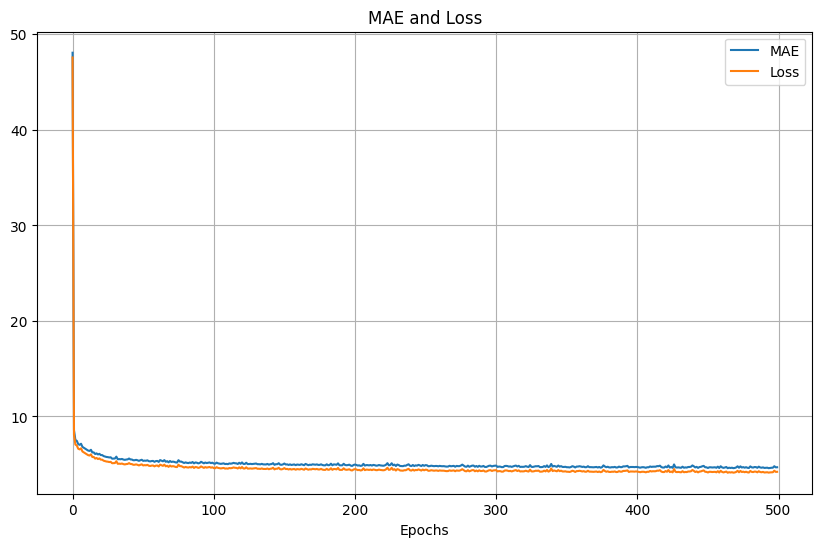

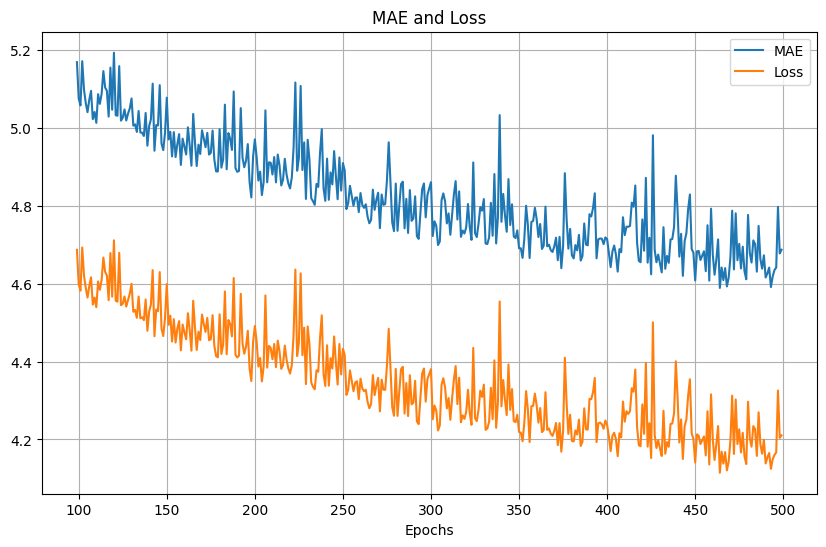

In [19]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

## Model Prediction

Once training is done, you can generate the model predictions and plot them against the validation set.


In [16]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


2024-07-11 10:13:07.110197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


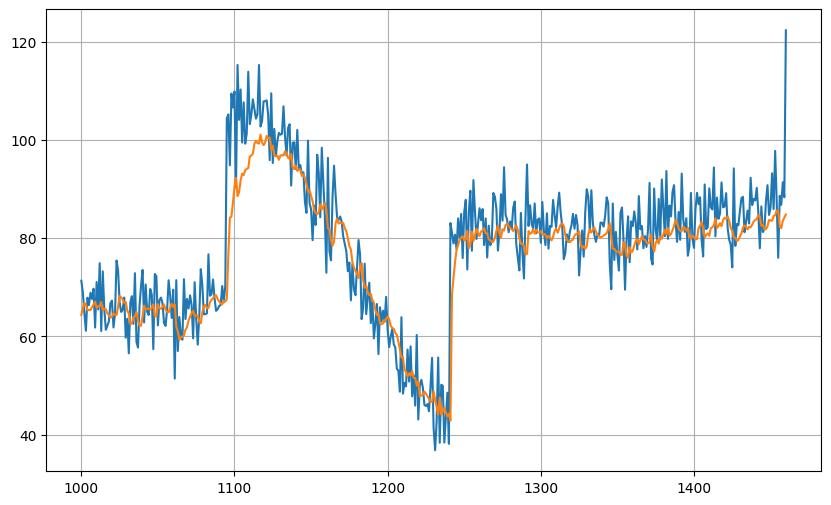

In [17]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then compute the metrics as usual.

In [20]:
## Compute the MAE and MSE
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

50.987595
5.193983


## Wrap Up

In this lab, you were able to build and train a CNN-RNN model for forecasting. This concludes the series of notebooks on training with synthetic data. In the next labs, you will be looking at a real world time series dataset, particularly sunspot cycles. See you there!

## Optional - Adding a Callback for Early Stopping

In this optional section, you will add a callback to stop training when a metric is met. You already did this in the first course of this specialization and now would be a good time to review.

First, you need to prepare a validation set that the model can use and monitor. As shown in the previous lab, you can use the `windowed_dataset()` function to prepare this.

In [ ]:
# Generate data windows from the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

You can reset the weights of the model or just continue from where you left off.

In [ ]:
# Uncomment if you want to reset the weights
# model.set_weights(init_weights)

Next, you will define a callback function that is run every end of an epoch. Inside, you will define the condition to stop training. For this lab, you will set it to stop when the `val_mae` is less than `5.2`.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when a certain metric is met

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the validation set MAE
    if(logs.get('val_mae') < 5.2):

      # Stop if threshold is met
      print("\nRequired val MAE is met so cancelling training!")
      self.model.stop_training = True

# Instantiate the class
callbacks = myCallback()

Remember to set an appropriate learning rate here. If you're starting from random weights, you may want to use the same rate you used earlier. If you did not reset the weights however, you can use a lower learning rate so the model can learn better. If all goes well, the training will stop before the set 500 epochs are completed.

In [ ]:
# Set the learning rate
learning_rate = 4e-8

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set, epochs=500, validation_data=val_set, callbacks=[callbacks])

In practice, you normally have a separate test set to evaluate against unseen data. For this exercise however, the dataset is already very small so let's just use the same validation set just to verify that the results are comparable to the one you got earlier.

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

The computed metrics here will be slightly different from the one shown in the training output because it has more points to evaluate. Remember that `x_valid` has 461 points that corresponds to `t=1000` to `t=1460`. `val_set` (which is a windowed dataset from `x_valid`), on the other hand, only has 441 points because it cannot generate predictions for `t=1000` to `t=1019` (i.e. windowing will start there).

In [ ]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())